# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix as confusion_matrix_fn
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     truck       ship        cat       ship


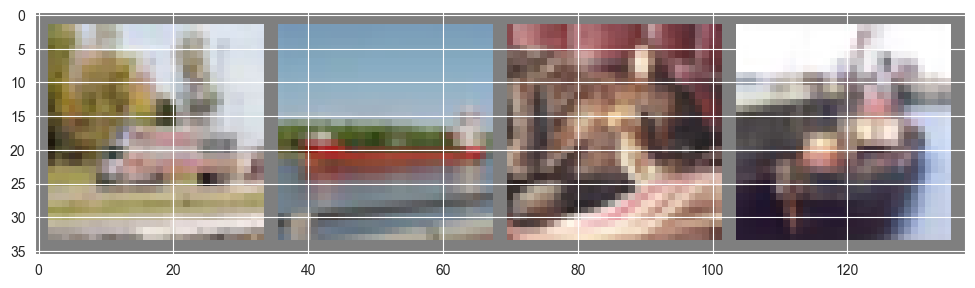

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader) # Get an iterator for the training set
images, labels = next(dataiter) # Get next batch from train loader.

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

In [4]:
print(trainloader.batch_size)

64


    ### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.out_channels1 = 16
        self.out_channels2 = 32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.out_channels1, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(self.out_channels1)
        self.conv2 = nn.Conv2d(in_channels=self.out_channels1, out_channels=self.out_channels2, kernel_size=5, stride=3)
        self.bn2 = nn.BatchNorm2d(self.out_channels2)
        self.fc1 = nn.Linear(self.out_channels2*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        x = self.bn2(self.conv2(x))
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch 1, Loss: 1.492
Epoch 2, Loss: 1.227
Epoch 3, Loss: 1.100
Epoch 4, Loss: 1.013
Epoch 5, Loss: 0.940
Epoch 6, Loss: 0.879
Epoch 7, Loss: 0.830
Epoch 8, Loss: 0.790
Epoch 9, Loss: 0.750
Epoch 10, Loss: 0.721
Finished Training for model with architecture:Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


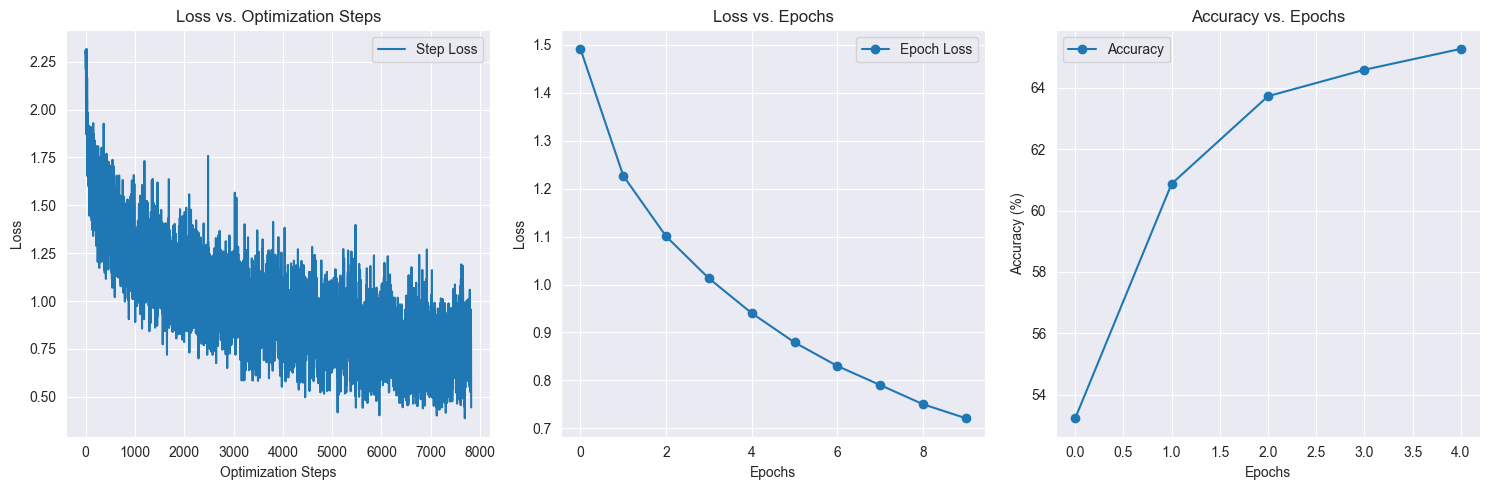

CPU times: total: 1min 53s
Wall time: 1min 46s


In [6]:
%%time
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################
epochs_num = 10
step_losses = []
epoch_losses = []
epoch_accuracies = []

def calculate_accuracy(loader, model, test=False):
    """
    Calculates the accuracy of the model on the given loader
    """
    correct = 0
    total = 0
    if test:
        preds = []
        actuals = []
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            if test:
                preds.append(predicted.numpy())
                actuals.append(labels.numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if test:
        print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), (100 * correct / total)))
        return np.concatenate(preds, axis=0), np.concatenate(actuals, axis=0)

    return 100 * correct / total

for epoch in range(epochs_num):
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Stats tracking
        step_losses.append(loss.item())
        running_loss += loss.item()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(trainloader)
    epoch_losses.append(epoch_loss)
    # Calculate accuracy evey second epoch
    if epoch % 2 == 0:
        epoch_accuracy = calculate_accuracy(testloader, net)
        epoch_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.3f}')

print(f"Finished Training for model with architecture:{net}")

# Plotting progresses: loss / GS optimizer step, loss / epoch, training_accuracy / epochs
plt.figure(figsize=(15, 5))

# Loss as a function of optimization steps
plt.subplot(1, 3, 1)
plt.plot(step_losses, label='Step Loss')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.title('Loss vs. Optimization Steps')
plt.legend()

# Loss as a function of epochs
plt.subplot(1, 3, 2)
plt.plot(epoch_losses, label='Epoch Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Accuracy as a function of epochs
plt.subplot(1, 3, 3)
plt.plot(epoch_accuracies, label='Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

In [7]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################
predictions, labels = calculate_accuracy(testloader, net, True)
confusion_matrix = confusion_matrix_fn(labels, predictions, normalize='true')
    #############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Model accuracy on 10000 test images: 64.26%


plane: accuracy: 66.8%
car: accuracy: 81.7%
bird: accuracy: 54.7%
cat: accuracy: 45.0%
deer: accuracy: 61.2%
dog: accuracy: 46.0%
frog: accuracy: 75.8%
horse: accuracy: 68.5%
ship: accuracy: 71.2%
truck: accuracy: 71.7%


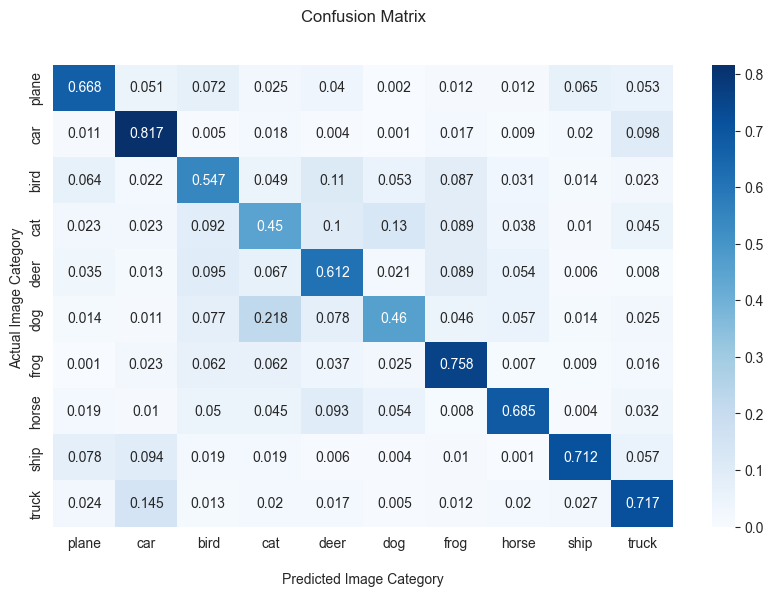

In [8]:
# print all classes accuracies
for class_i, row in enumerate(confusion_matrix):
    print(f'{classes[class_i]}: accuracy: {np.round(row[class_i]/np.sum(row)*100, 2)}%')

plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', vmin=0, fmt='g')
ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Image Category')
ax.set_ylabel('Actual Image Category ')

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
"""
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
"""
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:**

**Experiment 1:**  

Architecture: Conv(6 channels) -> ReLu -> Conv(16 channels) -> ReLu -> FC -> Loss

HyperParameters: {Optimizer - SGD with momentum, kernel - 5, Stride - 3 }

I based the initial try on the PyTorch documentation and the demonstration shown in the recitation.
Although the plots pointed the model does manage to improve from epoch to epoch, the rate of improvement wasn't satisfying.
So, before proceeding to the next experiment i was trying to effect the convergence speed by enlarging the learning rate , I could observe that the
training accuracy per epoch indeed improved when comparing one epoch to another but the final accuracy after  ~5 epochs was quite similar.
Putting these insights together, i decided to introduce more layers in order to introduce more complexity.

**Experiment 2:**

Architecture: Conv(16 channels) -> ReLu -> Conv(32 channels) -> ReLu -> FC -> ReLu -> FC -> ReLu -> FC -> Loss

HyperParameters: {Optimizer SGD with momentum, kernel 5, stride 3}

Indeed, introducing more complexity improved the model's accuracy dramatically but this improvement occurred mainly at the 1-3 first epochs, ending up with slight improvement of ~5% from the last experiment train accuracy.
Then, i tried out the Adam optimizer in the sake of trying. Experiment 2 architecture with Adam made the loss per epoch plot's slope smoother and even added another 2% to the training accuracy.
Putting this insights together i could conclude at this point:

- The current Architecture is quite complex already and so it's computation time.
- Manipulating hyperparameters utilized improvement without increasing the model's complexity

**Experiment 3:**

Architecture:
(conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  
I added batchnorm layers and maintained the usage of Adam optimizer.
These improved the model's ability to improve faster with same amount of epochs.


##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**

The model is less accurate for some classes than others. For example, it makes more mistakes with the 'cat' class. Overall accuracy doesn’t tell us how well the model works for each class. It’s important to see how the model performs for each class so we can improve it for the ones it struggles with. This also helps us find cases where the model often mixes up certain classes. A confusion matrix is a tool that shows this kind of information.









# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [9]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [10]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [12]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

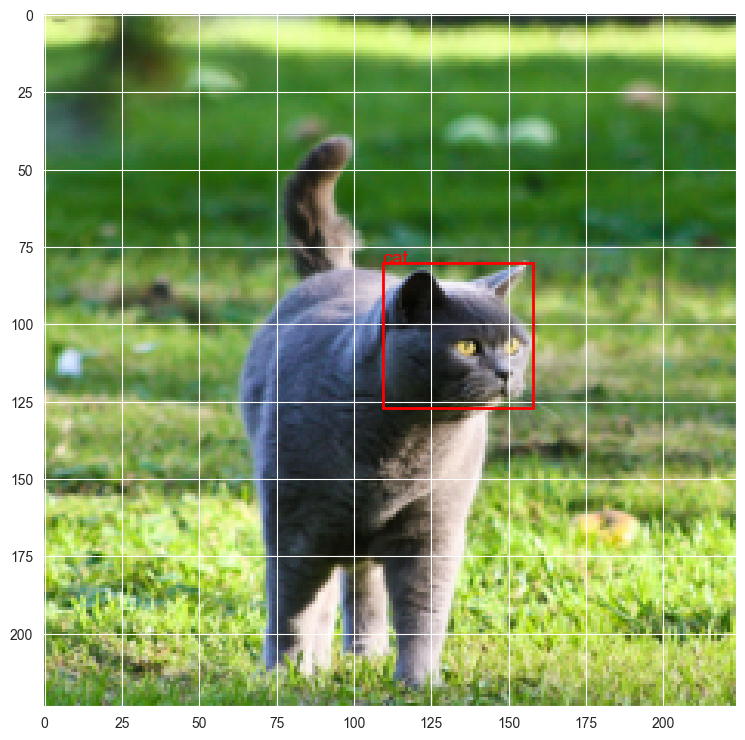

In [13]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        #resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet = resnet18

        # Get the number of features from ResNet18's final layer
        num_features = self.resnet.fc.in_features

        # Extracting resnet's original fc layer by setting it to identity
        self.resnet.fc = nn.Identity()

        # Create classification head
        self.classifier = nn.Sequential(
          nn.Linear(num_features, 256),
          nn.ReLU(),
          nn.Linear(256, num_classes)
        )

        # Create detection head
        self.detector = nn.Sequential(
          nn.Linear(num_features, 256),
          nn.ReLU(),
          #nn.Dropout(0.5),
          nn.Linear(256, 4)
        )



        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        with torch.no_grad():
            features = self.resnet(images)

        class_scores = self.classifier(features)
        bbox_pred = self.detector(features)
        return class_scores, bbox_pred
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [15]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    # Create lists to store metrics for visualization
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_ious, val_ious = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                # Get inputs and labels
                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)
                bbox_targets = sample['bbox'].to(device)

                optimizer.zero_grad()

                # Forward pass with gradients only in training
                #with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    # Get model predictions
                    class_scores, bbox_preds = model(inputs)

                    loss_cls = criterion_cls(class_scores, labels)
                    loss_bbox = criterion_bbox(bbox_preds, bbox_targets)
                    total_loss = loss_cls + 5.0 * loss_bbox

                    # Get classification preddictions
                    _, preds = torch.max(class_scores, 1)


                    total_loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        # Get model predictions
                        class_scores, bbox_preds = model(inputs)
                        loss_cls = criterion_cls(class_scores, labels)
                        loss_bbox = criterion_bbox(bbox_preds, bbox_targets)
                        total_loss = loss_cls + 5.0 * loss_bbox # Weighting the loss for getting better IOU

                        # Get classification preddictions
                        _, preds = torch.max(class_scores, 1)


                # Calculate metrics for this batch
                batch_size = inputs.size(0)
                running_loss += total_loss.item() * batch_size
                running_corrects += torch.sum(preds == labels)

                # Calculate IoU for this batch
                batch_iou = 0.0
                # Move predictions and targets to CPU and convert to numpy for IoU calculatio
                bbox_targets_np = bbox_targets.detach().cpu().numpy()
                bbox_preds_np = bbox_preds.detach().cpu().numpy()
                # Calculate IoU for each image in the batch
                for pred_box, target_box in zip(bbox_preds_np, bbox_targets_np):
                    batch_iou += bb_intersection_over_union(pred_box, target_box)

                iou += batch_iou
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()
            epoch_iou = (iou.item() / dataset_sizes[phase])

            # Store metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
                train_ious.append(epoch_iou)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                val_ious.append(epoch_iou)

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Return model and training history for visualization
    history = {
        'train_loss': train_losses, 'val_loss': val_losses,
        'train_acc': train_accs, 'val_acc': val_accs,
        'train_iou': train_ious, 'val_iou': val_ious
    }
    return model, history

*Choose* your optimizer and the loss functions for the classification and bounding box regression.

In [16]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
# For classification, we'll use Cross Entropy Loss
criterion_cls = nn.CrossEntropyLoss()

# For bounding box regression, we'll use Smooth L1 Loss (also known as Huber Loss)
# This is preferred over MSE Loss for bounding box regression because it's
# less sensitive to outliers and provides more stable gradients
# Based on https://wiki.cloudfactory.com/docs/mp-wiki/loss/bounding-box-regression-loss
criterion_bbox = nn.SmoothL1Loss()

# For the optimizer, we'll use Adam with a relatively small learning rate
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [17]:
best_model, history = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.5183  |  Acc: 0.8538  |  IOU: 0.5921
val Loss: 0.1310  |  Acc: 0.9873  |  IOU: 0.6990
Epoch 2/10
----------
train Loss: 0.1316  |  Acc: 0.9748  |  IOU: 0.7201
val Loss: 0.0781  |  Acc: 0.9873  |  IOU: 0.7361
Epoch 3/10
----------
train Loss: 0.1055  |  Acc: 0.9764  |  IOU: 0.7464
val Loss: 0.0832  |  Acc: 0.9810  |  IOU: 0.7462
Epoch 4/10
----------
train Loss: 0.1405  |  Acc: 0.9497  |  IOU: 0.7626
val Loss: 0.0682  |  Acc: 1.0000  |  IOU: 0.7422
Epoch 5/10
----------
train Loss: 0.0665  |  Acc: 0.9890  |  IOU: 0.7696
val Loss: 0.0614  |  Acc: 1.0000  |  IOU: 0.7542
Epoch 6/10
----------
train Loss: 0.0620  |  Acc: 0.9937  |  IOU: 0.7633
val Loss: 0.0634  |  Acc: 0.9937  |  IOU: 0.7572
Epoch 7/10
----------
train Loss: 0.0483  |  Acc: 0.9984  |  IOU: 0.7819
val Loss: 0.0598  |  Acc: 0.9937  |  IOU: 0.7632
Epoch 8/10
----------
train Loss: 0.0837  |  Acc: 0.9780  |  IOU: 0.7823
val Loss: 0.1097  |  Acc: 0.9810  |  IOU: 0.7451
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

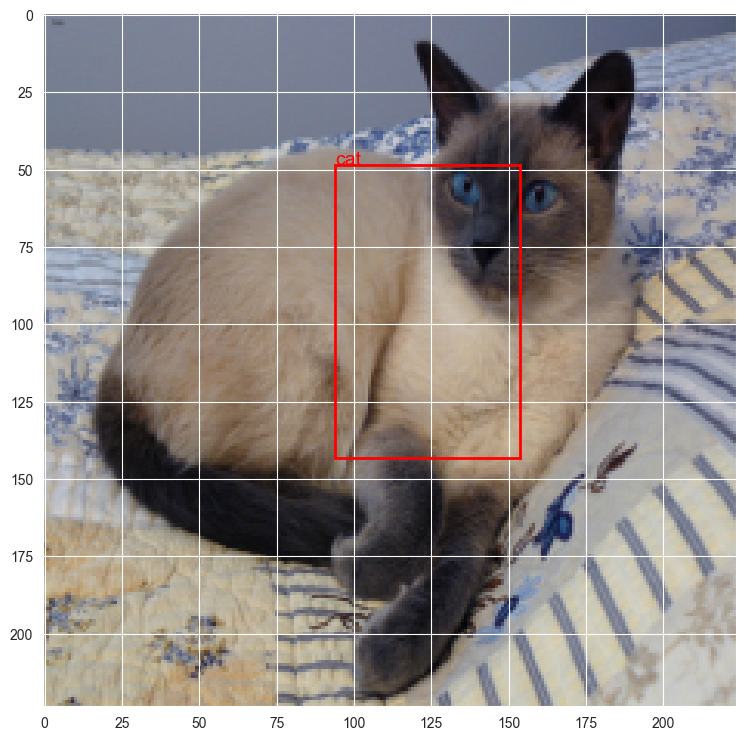

In [20]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

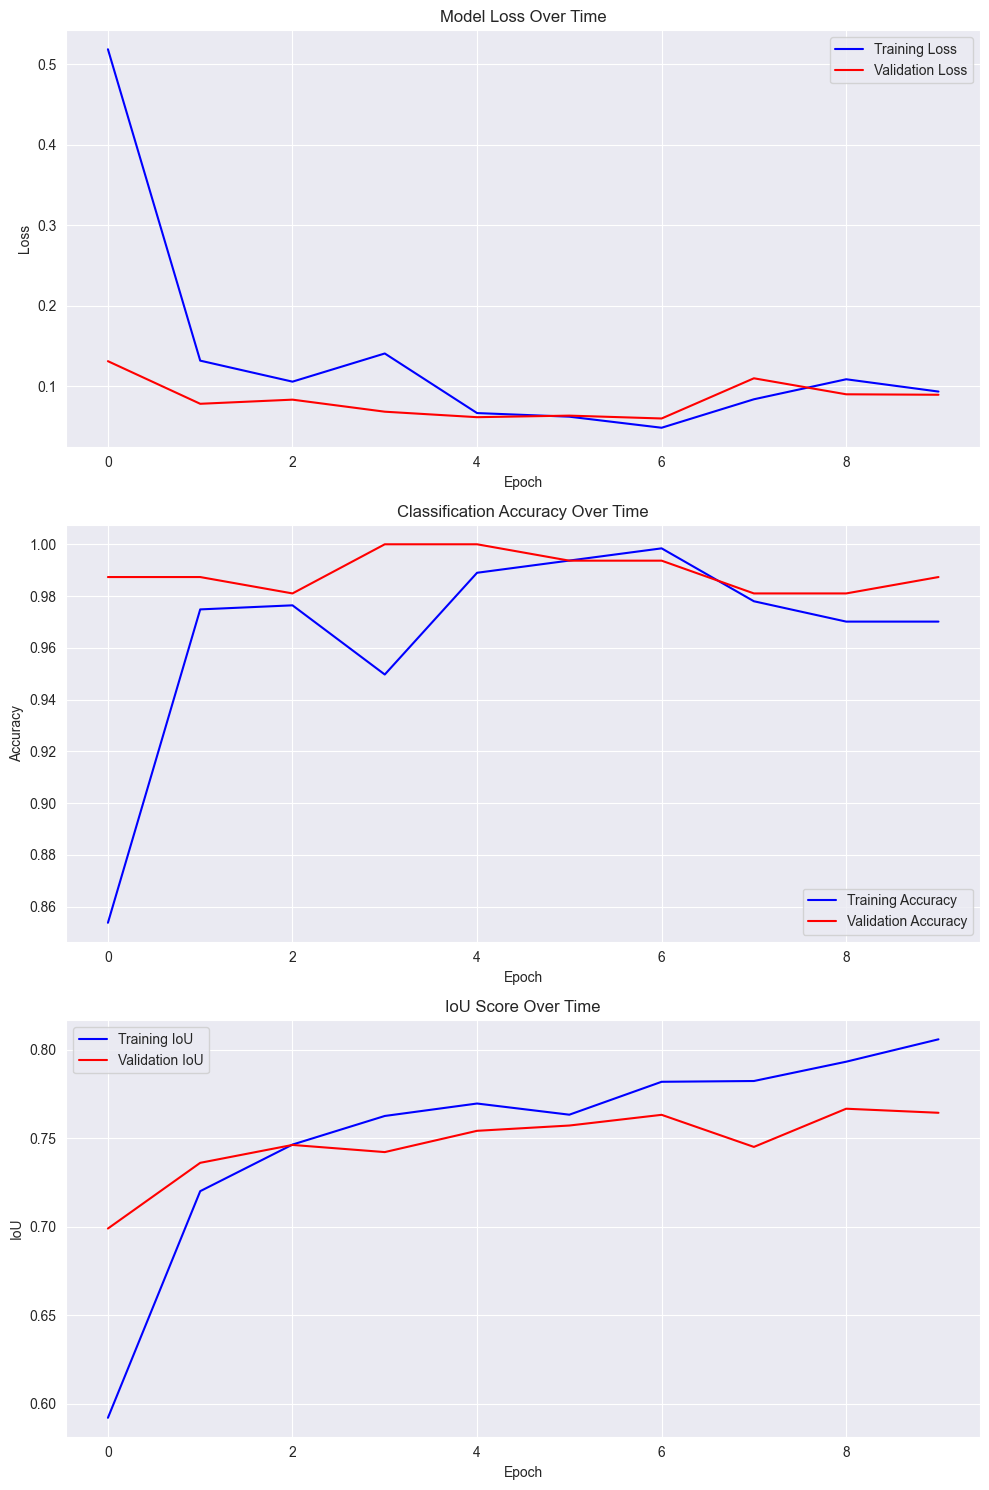

In [21]:
# Utility for vizualization:
def plot_training_progress(history):
    """
    Creates three subplots showing the training progression:
    1. Loss over time
    2. Classification accuracy over time
    3. IoU score over time
    Each plot compares training and validation metrics.
    """
    # Create a figure with three subplots arranged vertically
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Training Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Classification Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Plot IoU
    ax3.plot(history['train_iou'], label='Training IoU', color='blue')
    ax3.plot(history['val_iou'], label='Validation IoU', color='red')
    ax3.set_title('IoU Score Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('IoU')
    ax3.legend()
    ax3.grid(True)

    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()


plot_training_progress(history)

# **Results Explaination**



> **Architecture and loss:**
I have chosen for the object detection objective the Smooth L1 Loss
Smooth L1 loss, also known as Huber loss.
The squared term loss is used when the absolute loss falls below 1 and uses an absolute term otherwise. This makes it less sensitive to outliers and prevents exploding gradients. If the absolute loss is greater than 1, then the loss function is not squared which avoids high losses, and hence prevents exploding gradients.(Source: [link](https://wiki.cloudfactory.com/docs/mp-wiki/loss/bounding-box-regression-loss))
for coming up with the currrent model architecture i have begun as simple as possible and added only one FC layer to each task upon the ResNet18 feature extracion pretrained layers.
Visualizing the training i could observe that the model seems to reach high accuracy scores on validation and test from the very beggining of the training phase, but while that being said, it wasn't the case with the localization task.
I looked up for object detection models and found out YOLO as a suitable inspiration. ([YOLO original paper](https://arxiv.org/pdf/1506.02640)), There, i could find feature extracion layers followed by 2 FC layers.
Additionaly, i have tried to manipulate the loss by weighting the bbox loss 5 times the classification loss in order to get better performance on the object detection task.



> **Model Evaluation:**
First,In the validation performance, the validation accuracy reaching 100% while having lower loss than training.
The higher validation accuracy might seem counterintuitive at first, but it makes sense when we consider the dataset size and characteristics. In a smaller validation set, it's easier to achieve perfect classification simply because there are fewer examples to get right. Our training set likely contains more varied and challenging examples, making it harder to achieve perfect accuracy there.

The disparity between loss and accuracy reveals something important about our combined loss function. Recall, i have utilized total loss combines two components:

Classification loss (for cat vs. dog prediction)
Bounding box regression loss (for localization)

When we see high accuracy but relatively higher loss, it suggests that while our model is excellent at classifying images (cat vs. dog), it might still be struggling with precise localization.

The loss values show an interesting pattern:

Training loss starts at 0.2723 and generally decreases
Validation loss starts much lower at 0.0959
Both losses fluctuate but validation loss often remains lower

This pattern, combined with no dropout layers, suggests our model might be in an interesting regime where it's actually finding it easier to fit the validation set than the training set. This could happen if our validation set contains slightly simpler examples.
The IoU scores tell another part of the story:

They start around 0.58-0.71 and improve gradually.
By the end, we achieve about 0.76-0.79 IoU
The validation IoU is generally close to but slightly different from training IoU.






